In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')

path_MG = '/content/drive/MyDrive/00gerem00/DL-AI-Project'
path_LM = '/content/drive/MyDrive/lorenzomeroni02/DL-AI-Project'

if os.path.exists(path_MG):
    os.chdir(path_MG)
    print(f"Lavoro sulla cartella di Geremia: {path_MG}")
elif os.path.exists(path_LM):
    os.chdir(path_LM)
    print(f"Lavoro sulla cartella di Lorenzo: {path_LM}")

base_dir = 'dataset'
if os.path.exists(base_dir):
    print("Dataset trovato! Puoi procedere con la EDA.")
else:
    print("Errore: Dataset non trovato. Controlla il percorso.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lavoro sulla cartella di Geremia: /content/drive/MyDrive/00gerem00/DL-AI-Project
Dataset trovato! Puoi procedere con la EDA.


In [3]:
from torchvision.datasets import ImageFolder

# 1. TROVIAMO IL PERCORSO ESATTO
# Spesso dentro 'dataset' c'è una sottocartella col nome del dataset (es. "leather-defect...")
# Questo codice cerca quella sottocartella automaticamente.
contenuto_base = os.listdir(base_dir)
sottocartella = [f for f in contenuto_base if os.path.isdir(os.path.join(base_dir, f))][0]
data_dir = os.path.join(base_dir, sottocartella)

print(f"Percorso dati individuato: {data_dir}")

# 2. COLLEGHIAMO IMAGEFOLDER
# Usiamo transform=None per ora perché in fase di EDA vogliamo vedere le immagini "al naturale"
dataset = ImageFolder(
    root = data_dir,
    transform = None)

# 3. VERIFICA CHE ABBIA FUNZIONATO
print(f"Dataset collegato con successo!")
print(f"Numero totale immagini: {len(dataset)}")
print(f"Classi trovate: {dataset.classes}")

# Esempio: Stampa la mappa tra nome classe e indice (utile per PyTorch)
print(f"Mappa indici: {dataset.class_to_idx}")

Percorso dati individuato: dataset/Leather Defect Classification
Dataset collegato con successo!
Numero totale immagini: 3600
Classi trovate: ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']
Mappa indici: {'Folding marks': 0, 'Grain off': 1, 'Growth marks': 2, 'loose grains': 3, 'non defective': 4, 'pinhole': 5}


In [4]:
from collections import Counter

# Utilizzo di Counter per la statistica delle dimensioni e di un set per i canali colore
size_counter = Counter()
color_modes = set()

# Iterazione del dataset leather_df per l'analisi campionaria
for image, label in dataset:
    # L'istanza image è di tipo PIL.Image
    size_counter[image.size] += 1
    color_modes.add(image.mode)

print("\nREPORT DIMENSIONI:")
for size, count in size_counter.items():
    print(f" - {size[0]}x{size[1]} pixel: {count} immagini")

print(f"\nMODALITA COLORE: {color_modes}")


REPORT DIMENSIONI:
 - 227x227 pixel: 3598 immagini
 - 4608x3288 pixel: 2 immagini

MODALITA COLORE: {'RGB'}


In [13]:
soglia_dimensione_px = 500

print("Avvio procedura di rimozione outlier...")

rimossi = 0

# Scansione ricorsiva delle directory
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            path_completo = os.path.join(root, file)

            try:
                with Image.open(path_completo) as img:
                    width, height = img.size

                    # Verifica se l'immagine supera la soglia
                    if width > soglia_dimensione_px or height > soglia_dimensione_px:
                        print(f"Rilevato outlier: {file} ({width}x{height})")

                        # Chiusura del file prima della rimozione per evitare conflitti
                        img.close()

                        # Rimozione fisica del file
                        os.remove(path_completo)
                        print(f" -> File eliminato definitivamente: {path_completo}")
                        rimossi += 1

            except Exception as e:
                print(f"Errore durante l'elaborazione di {file}: {e}")

print(f"\nProcedura completata. Totale file rimossi: {rimossi}")


Avvio procedura di rimozione outlier...

Procedura completata. Totale file rimossi: 0


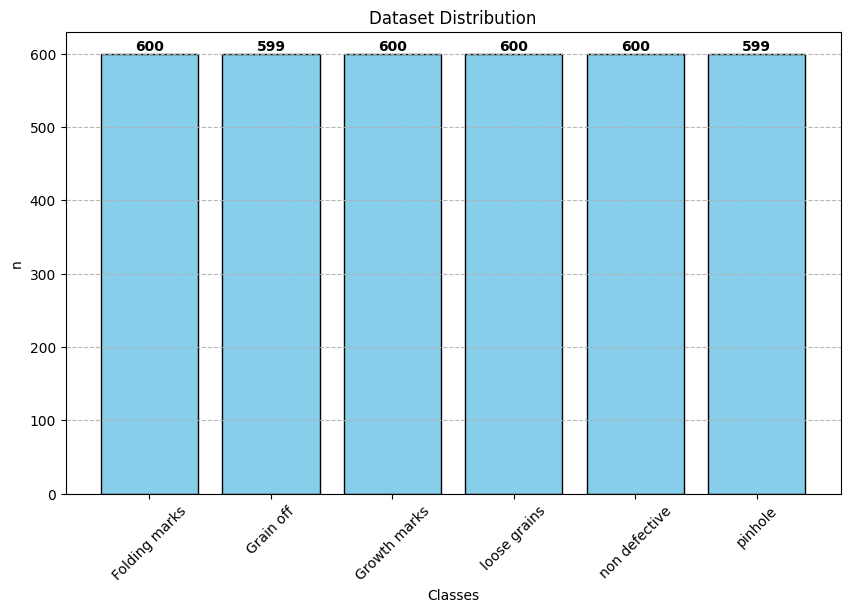

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Estrazione delle etichette (targets) dal dataset
# dataset.targets restituisce una lista di indici (es. [0, 0, 1, 2, ...])
labels = dataset.targets
counts = Counter(labels)

# Mappatura da indice numerico a nome della classe
class_names = dataset.classes
distribution = {class_names[idx]: count for idx, count in counts.items()}

# Generazione del grafico a barre
plt.figure(figsize=(10, 6))
plt.bar(distribution.keys(), distribution.values(), color='skyblue', edgecolor='black')
plt.xlabel('Classes')
plt.ylabel('n')
plt.title('Dataset Distribution')
plt.xticks(rotation = 45) # Rotazione etichette per leggibilità
plt.grid(axis = 'y', linestyle = '--', alpha = 0.9)

# Aggiunta del valore sopra ogni barra
for i, v in enumerate(distribution.values()):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.show()

In [24]:
dataset.classes

['Folding marks',
 'Grain off',
 'Growth marks',
 'loose grains',
 'non defective',
 'pinhole']

Here, we display a sample of size 9 of images in order to show how the dataset looks like.

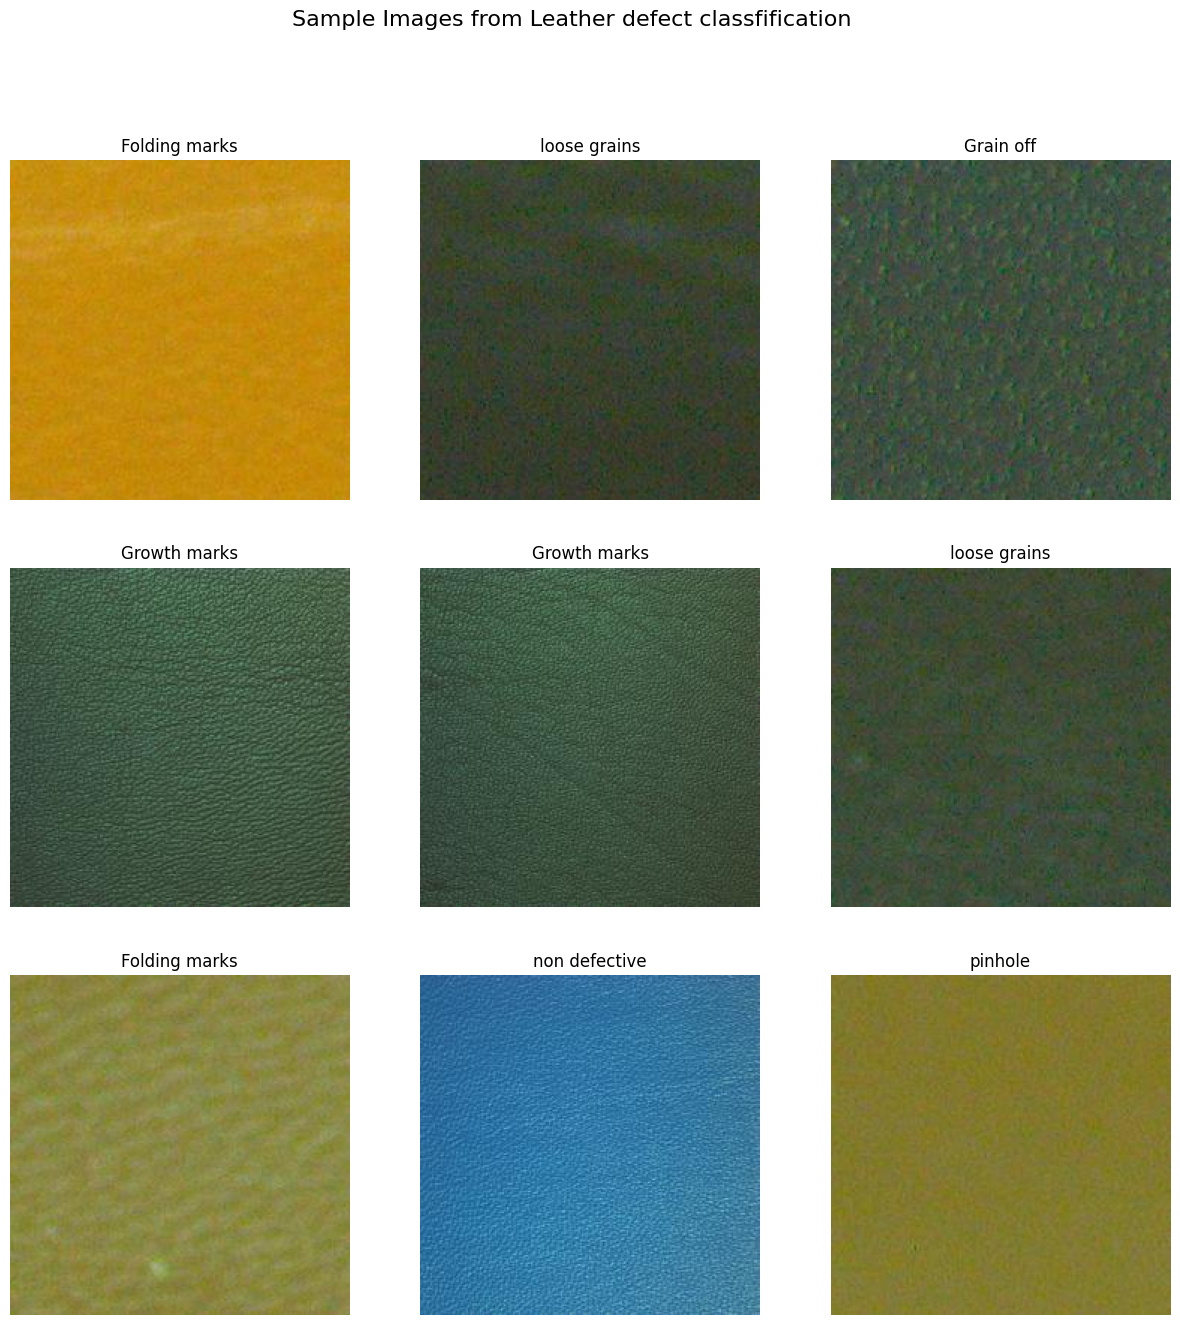

In [38]:
import random

plt.figure(figsize = (15, 15))

for i in range(9):
  idx = random.randint(0, len(dataset) - 1)
  img, label = dataset[idx]

  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(dataset.classes[label])
  plt.axis("off")

plt.suptitle("Sample Images from Leather defect classification", fontsize = 16)
plt.show()

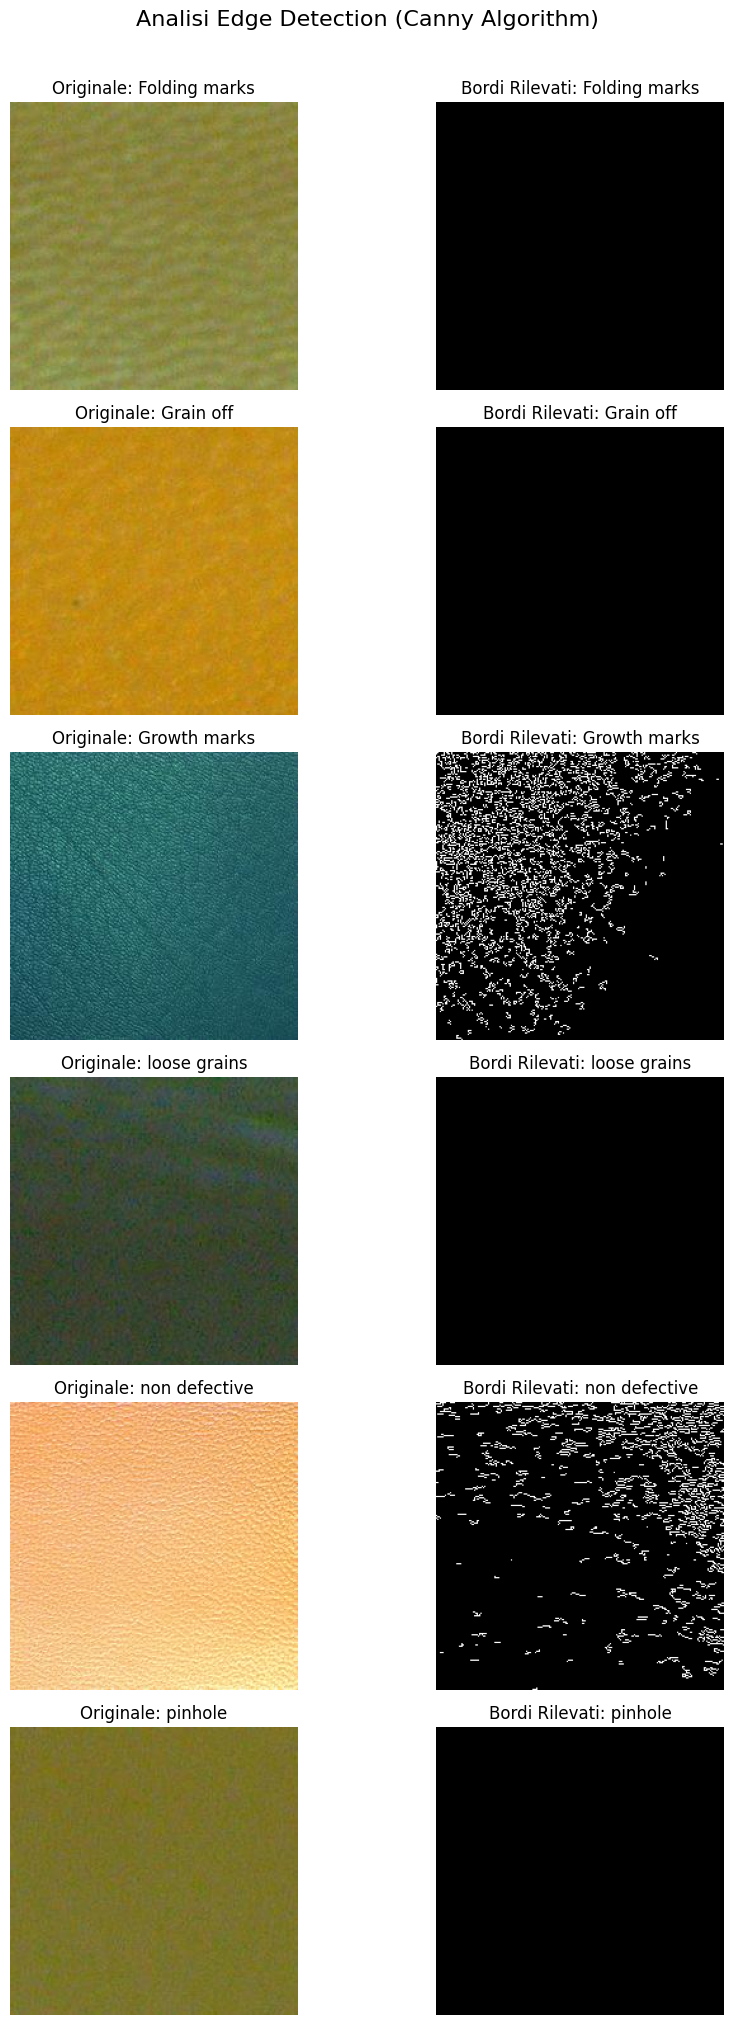

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 1. Selezione casuale di un'immagine per ogni classe
# Raggruppiamo gli indici per classe
indices_per_class = defaultdict(list)
for idx, label in enumerate(dataset.targets):
    indices_per_class[label].append(idx)

# Dizionario per salvare le immagini selezionate
selected_samples = {}

for label in sorted(indices_per_class.keys()):
    # Selezione casuale di un indice
    random_idx = random.choice(indices_per_class[label])
    img, _ = dataset[random_idx] # img è un oggetto PIL
    selected_samples[label] = img

# 2. Configurazione del grafico
# Creiamo una griglia con 6 righe (una per classe) e 2 colonne (Originale, Edges)
fig, axes = plt.subplots(len(dataset.classes), 2, figsize=(10, 20))
fig.suptitle("Analisi Edge Detection (Canny Algorithm)", fontsize=16, y=1.01)

# 3. Elaborazione e Visualizzazione
for i, label in enumerate(sorted(selected_samples.keys())):
    pil_image = selected_samples[label]
    class_name = dataset.classes[label]

    # Conversione da PIL a NumPy array per OpenCV
    img_np = np.array(pil_image)

    # Conversione in scala di grigi (necessaria per Edge Detection)
    # Nota: PIL usa RGB, OpenCV converte correttamente
    gray_image = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    # Applicazione Canny Edge Detector
    # Parametri: soglia minima (100) e massima (200) per l'isteresi
    edges = cv2.Canny(gray_image, 100, 200)

    # Colonna 1: Immagine Originale
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f"Originale: {class_name}")
    axes[i, 0].axis('off')

    # Colonna 2: Edge Detection
    axes[i, 1].imshow(edges, cmap='gray')
    axes[i, 1].set_title(f"Bordi Rilevati: {class_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

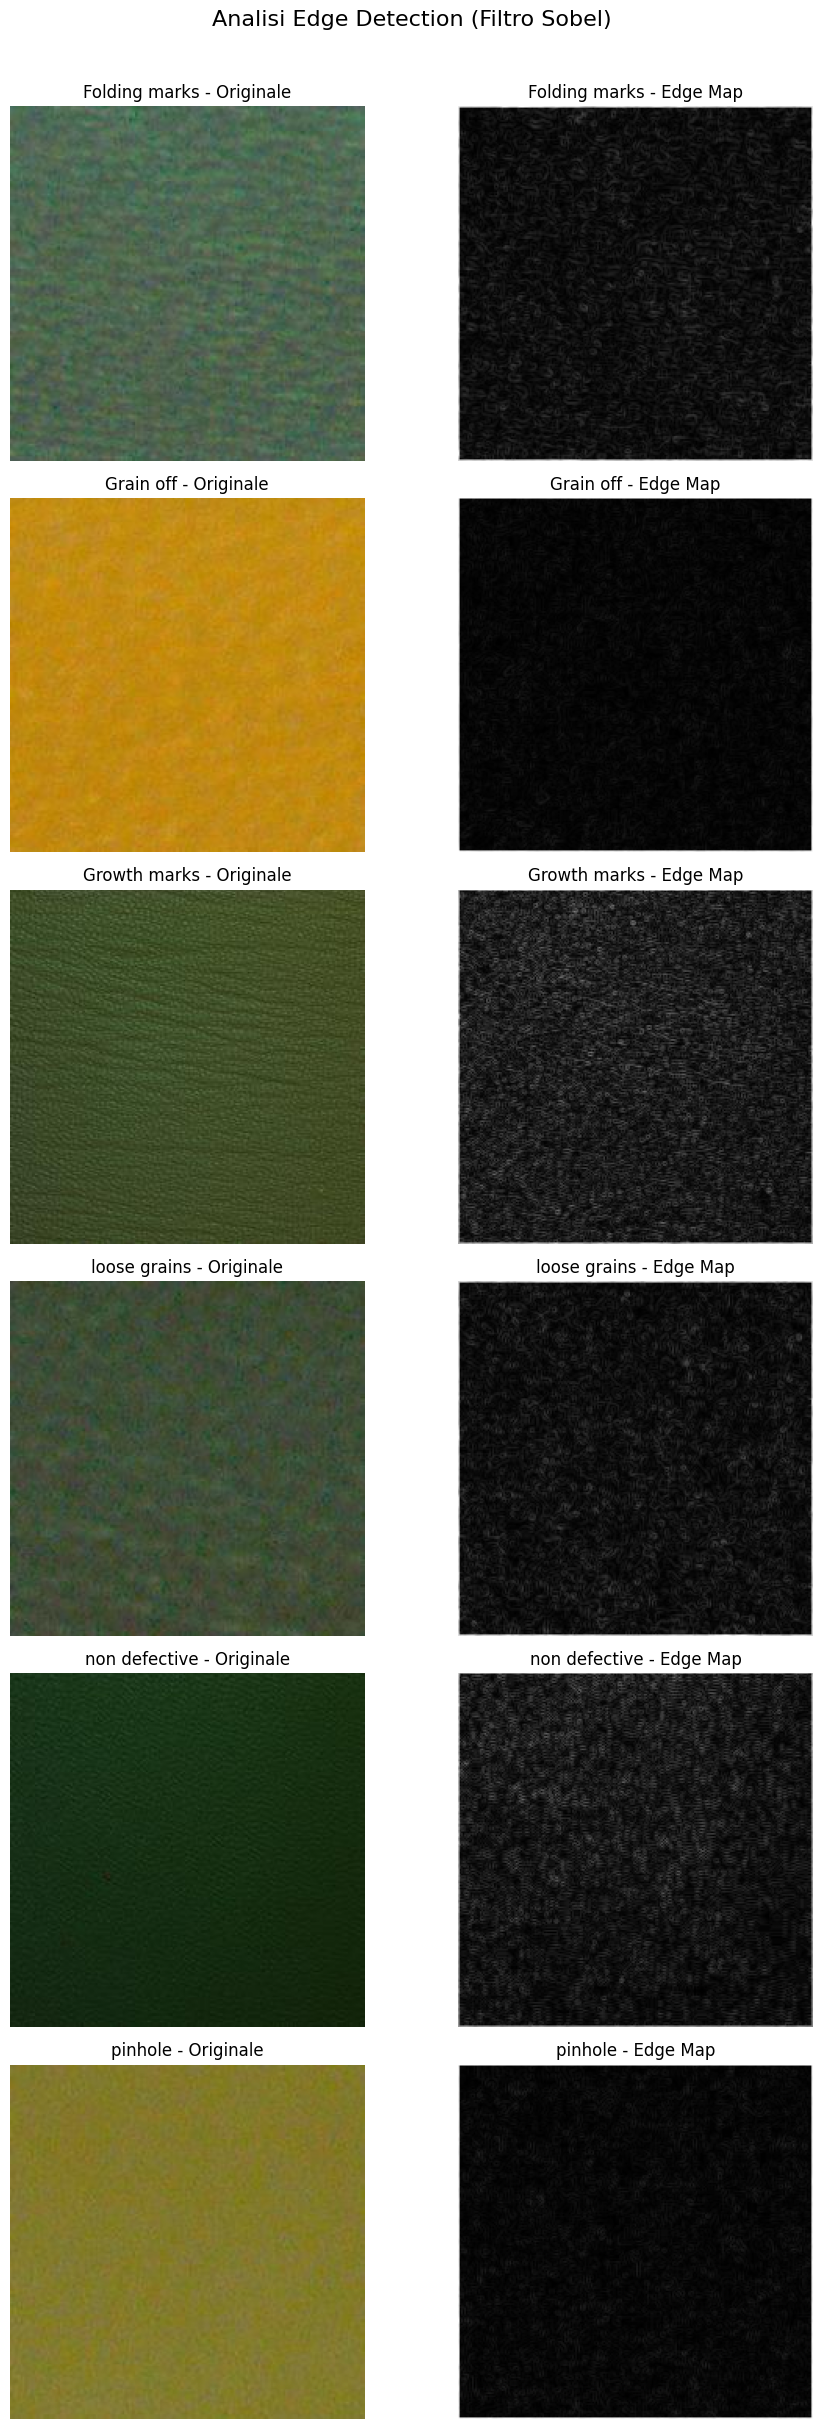

In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torchvision import transforms
from collections import defaultdict

# 1. Definizione della funzione di Edge Detection (Filtro di Sobel)
def apply_sobel_edge_detection(img_tensor):
    """
    Applica il filtro di Sobel a un tensore immagine (C, H, W).
    Restituisce la magnitudo del gradiente.
    """
    # Conversione in scala di grigi se l'immagine è RGB (3 canali)
    if img_tensor.shape[0] == 3:
        weights = torch.tensor([0.299, 0.587, 0.114]).view(3, 1, 1)
        img_gray = (img_tensor * weights).sum(dim=0, keepdim=True)
    else:
        img_gray = img_tensor

    # Aggiunta dimensione batch: da (1, H, W) a (1, 1, H, W)
    img_gray = img_gray.unsqueeze(0)

    # Definizione Kernel Sobel X (Rileva bordi verticali)
    kx = torch.tensor([[-1.0, 0.0, 1.0],
                       [-2.0, 0.0, 2.0],
                       [-1.0, 0.0, 1.0]]).view(1, 1, 3, 3)

    # Definizione Kernel Sobel Y (Rileva bordi orizzontali)
    ky = torch.tensor([[-1.0, -2.0, -1.0],
                       [0.0, 0.0, 0.0],
                       [1.0, 2.0, 1.0]]).view(1, 1, 3, 3)

    # Applicazione della convoluzione
    gx = F.conv2d(img_gray, kx, padding=1)
    gy = F.conv2d(img_gray, ky, padding=1)

    # Calcolo della magnitudo del gradiente
    edges = torch.sqrt(gx**2 + gy**2)

    return edges.squeeze()

# 2. Selezione di un'immagine casuale per ogni classe
indices_per_class = defaultdict(list)
# Verifica che dataset.targets sia accessibile, altrimenti usa un ciclo manuale
try:
    targets = dataset.targets
except AttributeError:
    targets = [label for _, label in dataset]

for idx, label in enumerate(targets):
    indices_per_class[label].append(idx)

selected_images = {}
for label in sorted(indices_per_class.keys()):
    random_idx = random.choice(indices_per_class[label])
    img, _ = dataset[random_idx]
    selected_images[label] = img

# 3. Visualizzazione (Originale vs Edge Detection)
num_classes = len(selected_images)
fig, axes = plt.subplots(num_classes, 2, figsize=(10, 4 * num_classes))
fig.suptitle("Analisi Edge Detection (Filtro Sobel)", fontsize=16, y=1.01)

converter = transforms.ToTensor()

for idx, label in enumerate(sorted(selected_images.keys())):
    # Immagine originale (PIL)
    original_img_pil = selected_images[label]
    label_name = dataset.classes[label]

    # Conversione in Tensore SOLO per il calcolo
    img_tensor = converter(original_img_pil)

    # Applicazione del filtro
    edges_img = apply_sobel_edge_detection(img_tensor)

    # Plot Immagine Originale (Matplotlib gestisce PIL nativamente)
    ax_orig = axes[idx, 0]
    ax_orig.imshow(original_img_pil)
    ax_orig.set_title(f"{label_name} - Originale")
    ax_orig.axis('off')

    # Plot Edge Detection (Tensore)
    ax_edge = axes[idx, 1]
    ax_edge.imshow(edges_img, cmap='gray')
    ax_edge.set_title(f"{label_name} - Edge Map")
    ax_edge.axis('off')

plt.tight_layout()
plt.show()